In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from kaggle.competitions import nflrush
import tqdm
import re
from string import punctuation
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import lightgbm as lgb

sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]

In [86]:
%load_ext autoreload
%aimport utils
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
# from utils import preprocess_features, sort_df, make_x, make_y

In [88]:
df_train = pd.read_csv('data/train.csv', dtype={'WindSpeed': 'object'})

In [89]:
df_train_preprocessed = utils.preprocess_features(df_train)

In [90]:
X_train = utils.make_x(df_train_preprocessed)
y_train = utils.make_y(X_train, df_train_preprocessed)

In [91]:
X_train.shape, y_train.shape

((22946, 295), (22946, 199))

# Helper functions

In [92]:
#from https://www.kaggle.com/davidcairuz/nfl-neural-network-w-softmax
def crps(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred), axis=1)

In [93]:
def yard_to_cdf(yard):
    yard = np.round(yard).astype(int)
    indices = yard+99
    cdfs = np.zeros((yard.shape[0], 199))
    for i in range(len(cdfs)):
        cdfs[i, indices[i]:] = 1
    return cdfs

def cdf_to_yard(cdf):
    yard_index = (cdf==1).argmax(axis=1)
    yard = yard_index-99
    return yard

In [94]:
# Turn yard cdf to yard number, \in (-99, 99)
y_train_yard_num = cdf_to_yard(y_train)
assert y_train_yard_num[0] == 8
print(y_train_yard_num)

[ 8  3  5 ...  4  2 11]


In [95]:
yard_to_cdf(y_train_yard_num)[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [96]:
assert (yard_to_cdf(y_train_yard_num) == y_train).all()

In [97]:
crps(y_train[:1], y_train[:1])

array([0.])

# Define CV scheme

In [108]:
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5)

# Scale data

In [109]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_train[:10]

array([[0.37296122, 0.77619777, 0.51066218, ..., 0.        , 0.14285714,
        0.34693878],
       [0.45351577, 0.35025159, 0.24242424, ..., 0.        , 0.14285714,
        0.42857143],
       [0.65458499, 0.64624809, 0.34567901, ..., 0.        , 0.28571429,
        0.65306122],
       ...,
       [0.87187387, 0.5957121 , 0.18855219, ..., 0.        , 0.14285714,
        0.90816327],
       [0.07919536, 0.3716911 , 0.67564534, ..., 0.        , 0.14285714,
        0.09183673],
       [0.49102936, 0.32246773, 0.04938272, ..., 0.        , 0.14285714,
        0.5       ]])

# Model CV

/home/boris/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


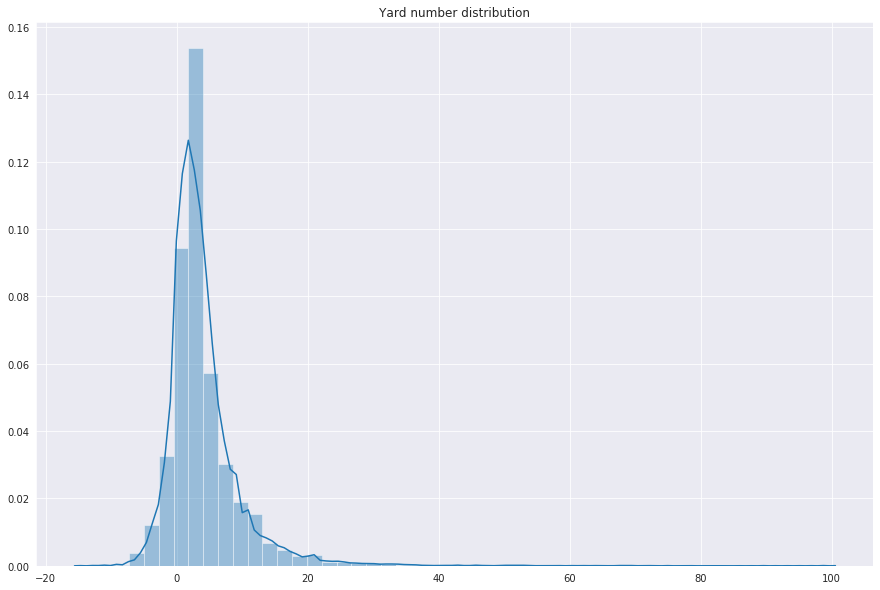

In [110]:
sns.distplot(y_train_yard_num)
plt.title('Yard number distribution')
plt.show()

In [111]:
def lgb_cprs_eval(preds, train_data):
    yards_true = train_data.label
    eval_name, is_higher_better = 'mean crps', False
    pred_cdfs = yard_to_cdf(preds)
    true_cdfs = yard_to_cdf(yards_true)
    errors = crps(true_cdfs, pred_cdfs)
    eval_result = np.mean(errors)
    return eval_name, eval_result, is_higher_better

In [112]:
lgb_train = lgb.Dataset(X_train, y_train_yard_num,
                       categorical_feature='auto')

In [113]:
lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'mse', 'mae'},
    'metric_freq': 5,
    'is_training_metric': True,
    'max_bin': 255,
    
    'max_depth': 4,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'tree_learner': 'serial',
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
    'verbose': 1,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0
}

In [114]:
eval_hist = lgb.cv(params=lgb_params, train_set=lgb_train, folds=cv.split(X_train, y_train), feval=lgb_cprs_eval)

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead.

/home/boris/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


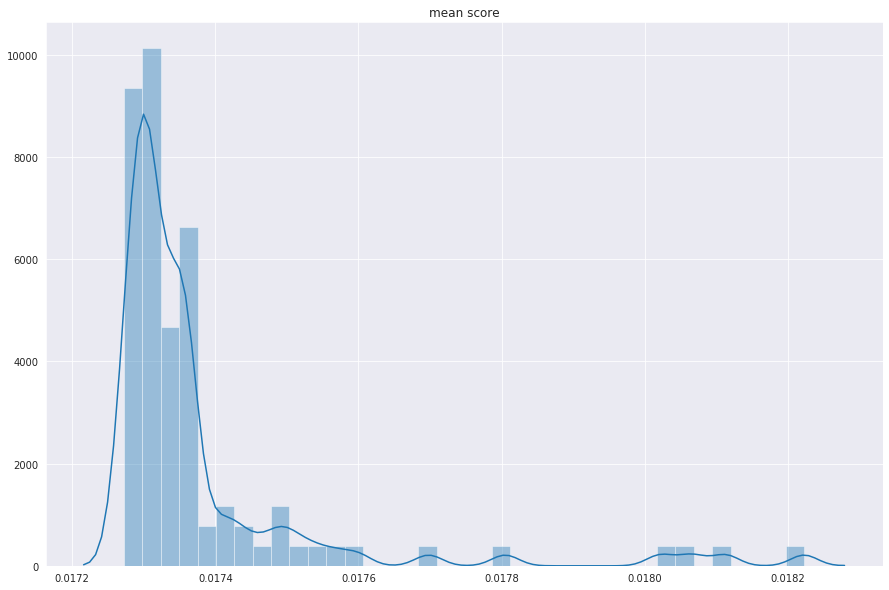

Mean loss 0.01737944912162499


In [105]:
plt.figure()
sns.distplot(eval_hist['mean crps-mean'])
plt.title('mean score')
plt.show()
print('Mean loss', np.mean(eval_hist['mean crps-mean']))

/home/boris/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


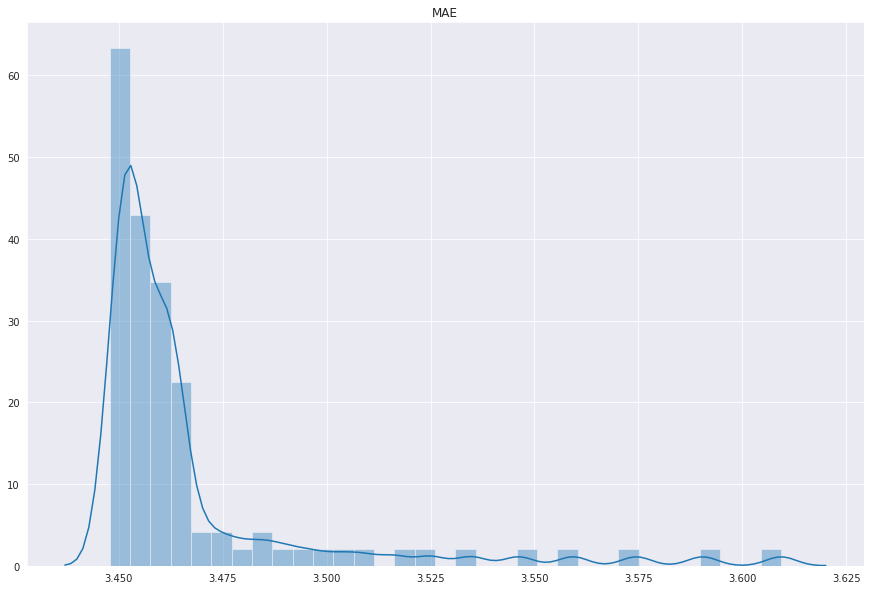

Mean MAE 3.467350598145851


In [106]:
plt.figure()
sns.distplot(eval_hist['l1-mean'])
plt.title('MAE')
plt.show()
print('Mean MAE', np.mean(eval_hist['l1-mean']))

In [107]:
# X_train, X_val, y_train_num, y_val_num = train_test_split(X_train, y_train_num
#                                         test_size=0.3,
#                                         stratify=train.Survived)